## European Call Option Hedging

Consider the example of an investor hedging a European contingent claim $H$ in an arbitrage free financial market of $d$ securities and $T$ trading periods until the maturity of $H$.
We identify the securities with their price processes $P^{(1)},\dots, P^{(d)}$ which we assume to be non-negative stochastic processes on a probability space $(\Omega, \mathcal{F}, \mathbb{P})$ adapted to a filtration $(\mathcal{G}_t)_{t=0}^T$. 
Additionally, $P^{(0)}$ shall refer to the money market account.
Write $P_t = (P^{(1)}_t, \dots, P^{(d)}_t)$.

We assume the price processes to have independent increments, meaning that for every security the process of its excess returns $(R^{(i)}_t)_{t=0}^T$, $$R^{(i)}_t = \Delta P^{(i)}_{t+1} / P^{(i)}_t,\quad t=0,\dots, T,$$ as a family of random variables, is independent.
Write $R_t = (R^{(1)}_t, \dots, R^{(d)}_t)$. 

The investor's self-financing hedging strategy corresponds to an adapted process $A=(A_0,\dots, A_T)$ with positions $A_t = (A^{(1)}_t,\dots, A^{(d)}_t)$ in $\mathbb{R}^d$ indicating at each time the net amounts invested into all but one of the market's securities:
Designating the missing security to be the money market account, then for the portfolio to indeed be self-financing the associated *wealth process* $(W_t)$ given by $W_t=\sum_{i=1}^d A^{(i)}_t + A^{(0)}_t$ where $A^{(0)}_t$ is the investor's position in the money market account must satisfy the condition $\Delta W_{t+1} = (A^{(0)}_t,A_t)\cdot (R^{(0)}_{t+1}, R_{t+1})$ at all times $t$.
Avoiding mention of $A^{(0)}$ but requiring explicit mention of $W_0$, equivalently have $$W_{t+1} = W_t + A_t\cdot R_{t+1} + \bigr(W_t - \sum_{i=1}^d A_t^{(i)}\bigr)R^{(0)}_{t+1},\quad t=0,\dots, T.$$ 

It is the hedging investor's objective to expect to incur a minimal *square replication error* $|W_T - H|^2$.
If the claim $H$ is attainable, then the unique initial endowment $W_0$ for which the replication error is expected to vanish constitutes the fair price of the claim $H$ at time $0$.

We recognize this problem to be a particular instance of a stochastic optimal control problem.
Because of the independent excess returns, the state relevant to the investor at each time $t$ is the current wealth of his portfolio together with the current market prices: $s_t = (w_t, p_t)$. 
The investor controls the state through his investments $a_t$ into the risky assets: $$F_t(s_t, a_t) = (w_t + a_t \cdot R_{t+1} - (w_t - \sum_t a_t)R^{(0)}_{t+1}, (1 + R_{t+1}) s_t)$$ which as a random function can easily be seen to factorize over the excess returns into a function $\tilde{F}$ on Euclidean space (equal for all times $t$): $F_t(s_t, a_t) = \tilde{F}(s_t, a_t, R_{t+1})$ with $$\tilde{F}(s_t, a_t, r_{t+1}) = (w_t + a_t\cdot r_{t+1}, (1 + r^{(0)}_{t+1}) p_t).$$ 

Setting $k_0,\dots, k_{T-1}$ to zero and $$k_T(s_T, a_T) = |H(s_T) - w_T|$$ we find that an optimal control for a such defined problem evaluates, in the invesor's context, to a perfect hedge.


# Imports

We have seen in the above that the optimal control problem lies in the scope of `ml_adp`.
We import packages to solve the optimal control problem using `ml_adp`:

In [169]:
import torch  # Required
import ml_adp.cost, ml_adp.finance, ml_adp.nn, ml_adp.mapping
import matplotlib.pyplot as plt  # Plotting
import copy  # Try different algorithms starting from same initial state
from tqdm import tqdm  # Progress bars for the optimization

# Device Settings

Enable GPU acceleration of the numerical simulation, if available.

In [170]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Market Specification

As a concrete example take

* the financial market to have $5$ trading periods and consist of a single risky asset trading at a current level of $100$: $T=5$, $d=1$ and $P_0 = 100$ (setting $P=P^{(1)}$ and $R=R^{(1)}$)
* A multinomial model for the securities returns: $R_0,\dots, R_T$ i.i.d. with law $3/10*\delta_{\{-0.05\}} + 1/10*\delta_{\{0\}} + 6/10 * \delta_{\{0.05\}}$
* The locally risk-free asset yielding nothing: $R_t^{(0)} = 0$ for all times $t$

In [171]:
number_periods = 5
number_risky_assets = 1

risk_free_rate = 0.

initial_value = 100.

rets = torch.tensor([0.05, -0.05, 0.0]).to(device)
probs = torch.tensor([0.6, 0.3, 0.1]).to(device)
multinomial_returns_sampler = ml_adp.finance.MultinomialReturnsSampler(rets, probs)

Also, we take $H$ to be a European call option on $S$ with maturity $5$ and strike equal to the initial price of $S$: $$H = (S_5 - 100)^+.$$
The module :py:class:`ml_adp.finance.EuropeanCallOption` implements such claims:

In [172]:
option = ml_adp.finance.EuropeanCallOption(strike=100., underlying_index=1)

As a callable, ``option`` will accept samples of states $s_T=(w_T, p_T)$ and produce the corresponding samples of payoffs.
:py:class:`ml_adp.finance.SquareReplicationError` saves any such callable (i.e., callables producing payoffs) and produces samples of the square replication error.
:py:class:`ml_adp.finance.MarketStep` instead implements the state transition function $\tilde{F}$ as defined in the beginning.

In [173]:
square_replication_error = ml_adp.cost.CostToGo.from_steps(number_periods)

square_replication_error.state_functions[:-1] = ml_adp.finance.MarketStep(risk_free_rate)
square_replication_error.cost_functions[-1] = ml_adp.finance.SquareReplicationError(option)

square_replication_error

CostToGo(
 step |          state_func          |         control_func         |          cost_func           
    0                                              None                           None             
    1          MarketStep(-)                       None                           None             
    2          MarketStep(-)                       None                           None             
    3          MarketStep(-)                       None                           None             
    4          MarketStep(-)                       None                           None             
    5          MarketStep(-)                       None                 SquareReplicatio...or(-)   
   (6)              None                                                                           
)

We know the analytical solution for this case:

In [174]:
def v0(wp, excess_returns=None):  # WIP: This is roughly estimated by hand
    wealth = wp[:, [0]]
    return .577 * (wealth ** 2) - 5.355 * wealth + 12.413248637

analytic_cost = ml_adp.cost.CostToGo.from_steps(0)
analytic_cost.cost_functions[0] = v0

The option has an analytic value of $4.5$:

In [175]:
analytic_cost(torch.tensor([4.5]))

tensor([[0.]])

# Control Function Specification

We are at the point at which the neural networks to be used for the control functions must be specified.
This, generally, is an exercise of the domain expert.
A such will have noticed that, in the present case, the lack of dependence of the cost functions on the random effects ("deterministic costs") implies an optimal control, effectively, to also not depend on the random effects. 
Moreover, he will be informed (by e.g. [arXiv:1812.05916v3](https://arxiv.org/abs/1812.05916v3)) that, in the given situation, the optimal control will depend linearly on the wealth level at each step and that the price levels parametrize these linear dependencies.
:py:class:`ml_adp.mapping.linear.LinearMap` implements learnable such parametrized linear maps by relying on an FFN to parametrize a linear transformation representation matrix.


In [176]:
class PFStrat(torch.nn.Module):
    def __init__(self, hidden_layer_sizes):
        super(PFStrat, self).__init__()
        # Have an FFN parametrize a linear insertion (of the wealth into the control space) with (d x 1)-representation matrix 
        config = (number_risky_assets, *hidden_layer_sizes, (number_risky_assets, 1))
        self.linear_map = ml_adp.mapping.linear.LinearMap.from_ffnconfig(config, translate=False)

    def forward(self, state, rand_eff=None):  # Deterministic costs mean no dependence on random effects
        # Inputs to the linear map is the wealth, parameter is the price
        return self.linear_map(state[:, [0]], state[:, 1:])

Set the control functions.
A configuration of two hidden layers with $35$ neurons each has been identified to work well for the controls of this particular instance of the option hedging problem:

In [190]:
hidden_layer_sizes = (35, 35)
for i in range(len(square_replication_error) - 1):
    square_replication_error.control_functions[i] = PFStrat(hidden_layer_sizes)

Inspect ``square_replication_error`` and sanity-check its representation:

In [191]:
square_replication_error

CostToGo(
 step |          state_func          |         control_func         |          cost_func           
    0                                         PFStrat(train)                      None             
    1          MarketStep(-)                  PFStrat(train)                      None             
    2          MarketStep(-)                  PFStrat(train)                      None             
    3          MarketStep(-)                  PFStrat(train)                      None             
    4          MarketStep(-)                  PFStrat(train)                      None             
    5          MarketStep(-)                       None                 SquareReplicatio...or(-)   
   (6)              None                                                                           
)

# Choosing the Training Distributions

For the training distributions, the domain expert defaults to a normal distribution that for the wealths has 95% of its mass contained in the interval $[0, 10]$ (which is expected to contain the price of the option for every trading period) and chooses, for the prices, again a normal distribution centered at the initial price $100$ and with the standard deviation increasing based on the number of trading periods into the market (reflecting his expectation of the distribution of the prices to get flatter with time).

In [192]:
from torch.distributions import multivariate_normal

class StateSampler:
    def __init__(self, step):
        loc = torch.tensor([5., initial_value]).to(device)
        scale = torch.diag(torch.tensor([5.5**2, (initial_value * (1+0.05)**max(step, 1)) - initial_value])).to(device)
        self.sampler = multivariate_normal.MultivariateNormal(loc, scale)
    
    def __call__(self, sims_size):
        return self.sampler.sample((sims_size,))

Create a dictionary containing all the relevant components:

In [193]:
model = {'cost_to_go': square_replication_error,
         'state_samplers': [StateSampler(step) for step in range(len(square_replication_error))],
         'random_effects_samplers': len(square_replication_error) * [multinomial_returns_sampler]}

# NNContPi

Create a fresh copy of the model and extract the components:

In [194]:
model = copy.deepcopy(model)

cost_to_go = model['cost_to_go']
state_samplers = model['state_samplers']
random_effects_samplers = model['random_effects_samplers']


The following optimization hyperparameters have proven themselves to work well:

In [195]:
gradient_descent_steps = 200 

optimizer_name = "Adam"
lr = 0.05  # Gradient descent step size
scheduler_name = "ExponentialLR"
gamma = 0.93

Choose the sample size for the Monte-Carlo simulation and perform the optimization routine:

In [196]:
sims_size = 10000  # Monte-Carlo Simulation Size

print("Optimizing the following model using NNContPi-Algorithm:")
print(cost_to_go.__repr__(include_id=True))

for step in reversed(range(len(cost_to_go) - 1)):
    
    state_sampler = state_samplers[step]
    random_effects_sampler = random_effects_samplers[step]

    rel_cost_to_go = cost_to_go[step:]
    optimizer = getattr(torch.optim, optimizer_name)(rel_cost_to_go.control_functions[0].parameters(), lr=lr)
    scheduler = getattr(torch.optim.lr_scheduler, scheduler_name)(optimizer, gamma=gamma)

    gradient_descent_iterations = tqdm(range(gradient_descent_steps))
    for iteration in gradient_descent_iterations:

        states = state_sampler(sims_size)
        rand_effs = random_effects_sampler(sims_size, len(rel_cost_to_go))

        cost = rel_cost_to_go(states, rand_effs).mean()
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
        if iteration % 10 == 0:
            scheduler.step()

        gradient_descent_iterations.set_description(f"Total cost of `cost_to_go[{step}:]`:  {cost:9.4f}")
    
    rel_cost_to_go.eval()

Optimizing the following model using NNContPi-Algorithm:
CostToGo(
 step |          state_func          |         control_func         |          cost_func           
    0                                     PFStrat(train;..8752)                   None             
    1       MarketStep(-;..2672)          PFStrat(train;..9136)                   None             
    2       MarketStep(-;..2672)          PFStrat(train;..1632)                   None             
    3       MarketStep(-;..2672)          PFStrat(train;..9904)                   None             
    4       MarketStep(-;..2672)          PFStrat(train;..9856)                   None             
    5       MarketStep(-;..2672)                   None                 SquareRep...or(-;..3280)   
   (6)              None                                                                           
)


Total cost of `cost_to_go[0:]`:    22.0696: 100%|██████████| 200/200 [00:20<00:00,  9.84it/s]


Note the time of each gadient descent iteration to increase with the steps of the backward pass.

Plot the expected square replication errors as implied by `cost_to_go` and the analytical solution against the initial wealth and for the initial price of $100$.

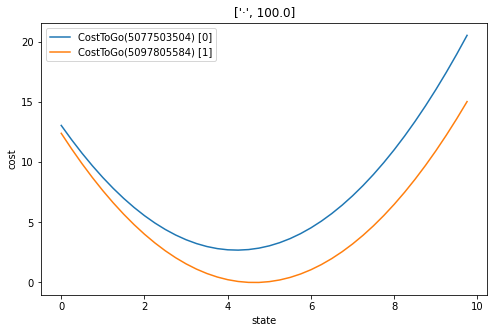

In [197]:
rand_effs = random_effects_samplers[-1](5000, len(cost_to_go))
with ml_adp.cost._evaluating(cost_to_go), torch.no_grad():
    cost_to_go.plot_state_component_range(torch.arange(0, 10, 0.25).to(device), torch.arange(100., 101., 1.).to(device), random_effects=rand_effs, versus=analytic_cost, plot_size=(8,5))

Approximately infer from the blue line the fair price of $4.5$ for the option and compare the analytical solution (orange).

# HybridNow

We start anew:

In [185]:
model = copy.deepcopy(model)

cost_to_go = model['cost_to_go']
state_samplers = model['state_samplers']
random_effects_samplers = model['random_effects_samplers']

We perform the optimization using the HybridNow algorithm (cf. [arXiv:1812.05916v3](https://arxiv.org/abs/1812.05916v3)) that includes value function approximation at each of the optimization steps of the above algorithm, ensuring a constant run-time for each of the backward iteration steps.
The domain expert will notice that the convexity of the cost function in the wealth-level translates to the convexity of the expected total cost in the wealth.
They decide to apply *partially input-convex neural networks* (as introduced in [arXiv:1609.07152v3](https://arxiv.org/abs/1609.07152v3) and implemented by :py:class:`ml_adp.mapping.convex.PICNN1`) for value function approximation because they expect a neural network with the right convexity properties backed into the architecture to begin with to lead to a more efficient traversal of the solution space:

In [198]:
class PFVal(torch.nn.Module):
    def __init__(self, input_hidden_sizes, param_hidden_sizes):
        super(PFVal, self).__init__()
        
        input_config = (1, *(input_hidden_sizes), 1)
        param_config = (1, *(param_hidden_sizes), 1)

        self.picnn = ml_adp.mapping.convex.PICNN1( 
                            input_config, 
                            param_config, 
                            hidden_activation=torch.nn.ELU(),
                            param_hidden_activation=torch.nn.ELU(),
                            floor_func=torch.nn.ReLU(),
                            uniform_init_range=(-5, -1)
                            )

    def forward(self, states, rand_effs=None):
        return self.picnn(states[:, [0]], states[:, 1:])

The following configurations have proven themselves to work well for the optimal control problem at hand:

In [199]:
input_hidden_sizes = (80,)
param_hidden_sizes = (80,)

# For the optimization of the PICNNs
approximation_optimizer = "Adam"
approximation_lr = 0.14094257426816312
approximation_gamma = 0.9998846278130944

approximation_gradient_descent_steps = 400
approximation_batch_size = 120

Optimizing the following model using Hybrid-Algorithm:
CostToGo(
 step |          state_func          |         control_func         |          cost_func           
    0                                     PFStrat(train;..8752)                   None             
    1       MarketStep(-;..2672)          PFStrat(train;..9136)                   None             
    2       MarketStep(-;..2672)          PFStrat(train;..1632)                   None             
    3       MarketStep(-;..2672)          PFStrat(train;..9904)                   None             
    4       MarketStep(-;..2672)          PFStrat(train;..9856)                   None             
    5       MarketStep(-;..2672)                   None                 SquareRep...or(-;..3280)   
   (6)              None                                                                           
)
Step 4:


Approximation Error: 6709.1060: 100%|██████████| 400/400 [00:43<00:00,  9.15it/s]


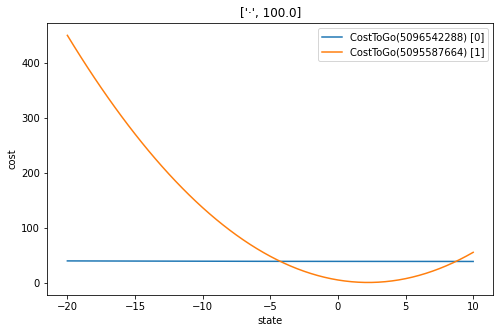

Step 3:


Approximation Error: 30028.1406:   5%|▌         | 20/400 [00:25<08:02,  1.27s/it]


KeyboardInterrupt: 

In [200]:
sims_size = 6000

print("Optimizing the following model using Hybrid-Algorithm:")
print(cost_to_go.__repr__(include_id=True))
cost_to_go.eval()

cost_approximators = []  # Create cost approximators on the fly and save in list
cost_approximator = cost_to_go[-1]  # First single-step cost approximator is exact

for step in reversed(range(len(cost_to_go) - 1)):

    print(f"Step {step}:")

    sub_ctg = cost_to_go[step] + cost_approximator
    state_sampler = state_samplers[step]
    random_effects_sampler = random_effects_samplers[step]

    # Control Optimization:
    sub_ctg.control_functions[0].train()    
    optimizer = getattr(torch.optim, optimizer_name)(sub_ctg.control_functions[0].parameters(), lr=lr)

    optimization_iterations = tqdm(range(gradient_descent_steps))
    for _ in optimization_iterations:
        
        rand_effs = random_effects_sampler(sims_size, len(rel_cost_to_go))
        state = state_sampler(sims_size)
        
        cost = sub_ctg(state, rand_effs).mean()
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

        optimization_iterations.set_description(f"Total cost of `cost_to_go[{step}:]`: {cost:9.4f}")

    # Cost Function Approximation
    sub_ctg.eval()
    cost_approximator = ml_adp.cost.CostToGo.from_steps(0)
    cost_approximator.cost_functions[0] = PFVal(input_hidden_sizes, param_hidden_sizes)
    cost_approximator.to(device)
    cost_approximators.insert(0, cost_approximator)
    optimizer = getattr(torch.optim, approximation_optimizer)(cost_approximator.cost_functions[0].parameters(), lr=approximation_lr)

    approximation_iterations = tqdm(range(approximation_gradient_descent_steps))
    for _ in approximation_iterations: 
        
        state = state_sampler(approximation_batch_size)
        rand_effs = random_effects_sampler(sims_size, len(sub_ctg))
        
        with torch.no_grad():
            cost = torch.tensor([sub_ctg(state, rand_effs).mean() for state in state])
        approx_cost = cost_approximator(state)
        approx_error = torch.norm(cost - approx_cost, p=2)

        approx_error.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        approximation_iterations.set_description(f"Approximation Error: {approx_error:9.4f}")

    cost_approximator.eval()
    with torch.no_grad():
        cost_approximator.plot_state_component_range(
            torch.arange(-20., 10.5, 0.5).to(device),
            torch.arange(100., 101.).to(device),
            random_effects=rand_effs,
            versus=sub_ctg,
            plot_size=(8,5)
        )
        plt.show()

    

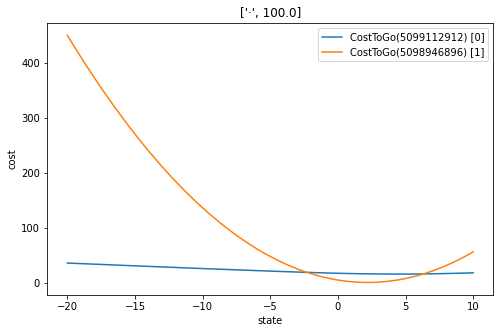

In [ ]:
cost_approximator.plot_state_component_range(
    torch.arange(-20., 10.5, 0.5).to(device),
    torch.arange(100., 101.).to(device),
    random_effects=rand_effs,
    versus=sub_ctg,
    plot_size=(8,5)
)
plt.show()